In [2]:
import pandas as pd
import numpy as np
from Bio import SeqIO
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('/home/saugat/Desktop/pymodulon/src')
from pymodulon import core, io


/home/saugat/anaconda3/envs/rnseq/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
ica_data = io.load_json_model('/home/saugat/Desktop/StaphPrecise2/docker_run/processed_data/saureus.json.gz')

In [4]:
lt_dict = {}
for rs in SeqIO.parse('/home/saugat/Desktop/Reference/genome/TCH1516_full.gb', 'genbank'):
    for feat in rs.features:
        if feat.type == "CDS":
            lt_dict.update({feat.qualifiers['locus_tag'][0]: feat.qualifiers['product'][0]})

In [5]:
all_nodes = pd.read_csv('/home/saugat/Desktop/project_cc8/FinalAnalysis/data/dbgwas/dbgwas_output/textualOutput/all_comps_nodes_info.tsv',
                        sep='\t')
all_nodes.reset_index(inplace=True)
all_nodes.drop('Annotations(sep=~~~)', inplace=True, axis=1)
all_nodes.columns = ['CompId', 'NodeId', 'AlleleFreq', 'Pheno0Count',
       'Pheno0TotalCount', 'Pheno1Count', 'Pheno1TotalCount', 'NACount',
       'NATotalCount', 'Significant?', 'p-value', 'q-Value', 'EstEffect',
       'WaldStat', 'Sequence', 'SequenceLength', 'Annotations(sep=~~~)']
all_nodes.head()
all_nodes.shape

(7277, 17)

In [6]:
sig_nodes = all_nodes[all_nodes['Significant?'] == 'Yes'].reset_index()
sig_nodes.loc[:, 'Annotations(sep=~~~)'] = sig_nodes['Annotations(sep=~~~)'].fillna("No Annotation")
sig_nodes.shape

(691, 18)

In [7]:
all_nodes = all_nodes.dropna(subset=['Annotations(sep=~~~)'])

In [8]:
all_nodes[all_nodes['Annotations(sep=~~~)'].str.contains('SAOUHSC_00581')]

,CompId,NodeId,AlleleFreq,Pheno0Count,Pheno0TotalCount,Pheno1Count,Pheno1TotalCount,NACount,NATotalCount,Significant?,p-value,q-Value,EstEffect,WaldStat,Sequence,SequenceLength,Annotations(sep=~~~)
1999,13,n255318,2029,588,589,1441,1441,0,0,No,NaN,NaN,NaN,NaN,TTTTTATGTTTTGTCTAGAAATTAAATAAATCATTAAATGATTCGG...,55,USA300HOU_RS03105;DBGWAS_general_tag=dihydroli...


In [9]:
#gff file
gff = pd.read_csv('/home/saugat/Desktop/Reference/genome/TCH1516.gff', sep='\t', header=None)

starts = gff[3].values
ends = gff[4].values

# Get the mutations in CDS

In [10]:
def parse_line(line, tag='USA300'):
    # cds mutants in USA300 strain
    parsed =  '|'.join([i for i in line.split(';') if tag in i])
    return parsed.split('~~~')[-1]

sig_nodes['tch_cds'] = np.where([sig_nodes['Annotations(sep=~~~)'].str.contains('USA300HOU')],
        sig_nodes['Annotations(sep=~~~)'].apply(parse_line, args=('USA300',)),
                            'Not Found')[0]

sig_nodes['nctc_cds'] = np.where([sig_nodes['Annotations(sep=~~~)'].str.contains('USA300HOU')],
        sig_nodes['Annotations(sep=~~~)'].apply(parse_line, args=('SAOUHSC',)),
                            'Not Found')[0]

In [11]:
# next get the sequence from both strains and assign mutations
def write_mutant_cds(genbank, faout, gene_list):
    with open(faout, 'w') as fout:
        for refseq in SeqIO.parse(genbank, 'genbank'):
            for feats in refseq.features:
                try:
                    lt = feats.qualifiers['locus_tag'][0]
                    product = feats.qualifiers['product'][0]
                except KeyError:
                    continue
                if lt in gene_list:
                    if 'translation' in feats.qualifiers:
                        seq = feats.qualifiers['translation'][0]
                    else:
                        seq = feats.extract(refseq).seq.translate()
                    fout.write(f'>{lt}|{product}\n{seq}\n')
write_mutant_cds('/home/saugat/Desktop/Reference/genome/TCH1516_full.gb',
                'data/scratch_data/tch_cds_mutants.fa',
                sig_nodes.tch_cds.values)

write_mutant_cds('/home/saugat/Desktop/Reference/genome/NCTC_8325.gbk',
                'data/scratch_data/nctc_cds_mutants.fa',
                sig_nodes.nctc_cds.values)

FileNotFoundError: [Errno 2] No such file or directory: 'data/scratch_data/tch_cds_mutants.fa'

In [12]:
tch_ref = SeqIO.parse('data/scratch_data/tch_cds_mutants.fa', 'fasta')

FileNotFoundError: [Errno 2] No such file or directory: 'data/scratch_data/tch_cds_mutants.fa'

In [13]:
def diff_seq(seq1, seq2):
    if len(seq1) != len(seq2):
        return 'Different sequence lengths'
    
    diff = []
    for i, aa in enumerate(seq1):
        if seq2[i] != aa:
            diff.append(f'{seq2[i]}{i}{aa}')
    return diff

nctc_ref = SeqIO.parse('data/scratch_data/nctc_cds_mutants.fa', 'fasta')
tch_ref = SeqIO.parse('data/scratch_data/tch_cds_mutants.fa', 'fasta')

nctc_seq = dict([(seq.description, str(seq.seq)[:-1]) for seq in nctc_ref]) # -1 remove '*' for stop
tch_seq = dict([(seq.description, str(seq.seq)) for seq in tch_ref])

FileNotFoundError: [Errno 2] No such file or directory: 'data/scratch_data/nctc_cds_mutants.fa'

In [307]:
fpr_seq = """MLNYNHNQIEKKWQDYWDENKTFKTNDNLGQKKFYALDMFPYPS
                     GAGLHVGHPEGYTATDIISRYKRMQGYNVLHPMGWDAFGLPAEQYALDTGNDPREFTK
                     KNIQTFKRQIKELGFSYDWDREVNTTDPEYYKWTQWIFIQLYNKGLAYVDEVAVNWCP
                     ALGTVLSNEEVIDGVSERGGHPVYRKPMKQWVLKITEYADQLLADLDDLDWPESLKDM
                     QRNWIGRSEGAKVSFDVDNTEGKVEVFTTRPDTIYGASFLVLSPEHALVNSITTDEYK
                     EKVKAYQTEASKKSDLERTDLAKDKSGVFTGAYATNPLSGEKVQIWIADYVLSTYGTG
                     AIMAVPAHDDRDYEFAKKFDLPIIEVIEGGNVEEAAYTGEGKHINSGELDGLENEAAI
                     TKAIQLLEQKGAGEKKVNYKLRDWLFSRQRYWGEPIPVIHWEDGTMTTVPEEELPLLL
                     PETDEIKPSGTGESPLANIDSFVNVVDEKTGMKGRRETNTMPQWAGSCWYYLRYIDPK
                     NENMLADPEKLKHWLPVDLYIGGVEHAVLHLLYARFWHKVLYDLAIVPTKEPFQKLFN
                     QGMILGEGNEKMSKSKGNVINPDDIVQSHGADTLRLYEMFMGPLDAAIAWSEKGLDGS
                     RRFLDRVWRLMVNEDGTLSSKIVTTNNKSLDKVYNQTVKKVTEDFETLGFNTAISQLM
                     VFINECYKVDEVYKPYIEGFVKMLAPIAPHIGEELWSKLGHEESITYQPWPTYDEALL
                     VDDEVEIVVQVNGKLRAKIKIAKDTSKEEMQEIALSNDNVKASIEGKDIMKVIAVPQK
                     LVNIVAK"""
fpr_seq = fpr_seq.translate(str.maketrans('', '', ' \n\t\r'))

In [14]:
for idx, row in sig_nodes[sig_nodes.tch_cds != 'Not Found'].iterrows():
    nname = [i for i in nctc_seq if row.nctc_cds in i]
    tname = [i for i in tch_seq if row.tch_cds in i]
    if len(nname) > 1 or len(tname) > 1:
        continue
    diff = diff_seq(nctc_seq[nname[0]], tch_seq[tname[0]])
    print(tname, nname, diff)

NameError: name 'nctc_seq' is not defined

In [15]:
for i in sig_nodes.tch_cds.unique():
    if i == 'Not Found':
        continue
    imod = ica_data.imodulons_with(i)
    if len(imod) > 0:
        print([j for j in tch_seq if i in j], imod) 

NameError: name 'tch_seq' is not defined

In [16]:
inter_sig = sig_nodes[(sig_nodes['Annotations(sep=~~~)'].str.contains('intergenic'))
         &(~sig_nodes.tch_cds.str.contains('USA300'))]

def parse_inter(line, tag='TCH1516intergenic'):
    if tag not in line:
        return 
    try:
        split = [i for i in line.split('~~~') if tag in i][0].split('_')[-1]
    except IndexError:
        split = line.split('_')
    start, stop = split.split('-')
    return int(start), int(stop)

tch_inter = np.where(inter_sig['Annotations(sep=~~~)'].str.contains('TCH1516intergenic'),
          inter_sig['Annotations(sep=~~~)'].apply(parse_inter, args=('TCH1516intergenic',)),
          'Not Found')
nctc_inter = np.where(inter_sig['Annotations(sep=~~~)'].str.contains('NCTC8325intergenic'),
          inter_sig['Annotations(sep=~~~)'].apply(parse_inter, args=('NCTC8325intergenic',)),
          'Not Found')
tch_inter, nctc_inter = list(set(tch_inter)), list(set(nctc_inter))

In [17]:
assign_genes(*tch_inter[0])

NameError: name 'assign_genes' is not defined

In [18]:
[assign_genes(*i) for i in tch_inter if i != 'Not Found']

NameError: name 'assign_genes' is not defined

In [19]:
def get_genes(annot, otype='gene_name'):
    if type(annot) == int:
        return 'No Match'
    split = annot.split('tag=')
    if otype == 'gene_name':
        return split[-1]
    return split[0].split(';')[0]
    
def assign_genes(start, end, otype='locus_tag', gff=gff):
    """for all intergenic region, find the upstream gene,
    downstream gene and strand of each"""
    name = ''
#     if type(annot) == int:
#         return 'No Match'
#     start, end = annot.split('_')[-1].split('-')
    loc = np.where(gff[4] == int(start))[0][0]
    if gff.loc[loc, 6] == '-':
        upstream = parse_descript(gff.loc[loc, 8], otype)
        name += upstream
    if gff.loc[loc + 1, 6] == '+':
        downstream = parse_descript(gff.loc[loc + 1, 8], otype)
        name += ' ' + downstream
         
    return name.lstrip()

def parse_descript(descript, otype):
    if otype == 'locus_tag':
        split1, split2 = 0, 'gene_id'

    elif otype == 'gene_name':
        split1, split2 = -2, 'gene_name'
    
    return descript.split(';')[split1].split(split2)[-1].strip().replace('\"','')
    
def get_tch(annot):
    return sig_nodes['Annotations(sep=~~~)'].str.split('~~~').apply(lambda x: x[0])

intergenic = np.where(sig_nodes['Annotations(sep=~~~)'].str.contains('TCH1516intergenic'), 
         get_tch(sig_nodes['Annotations(sep=~~~)']),
         0)
intergenic_genes = list(set(map(assign_genes, intergenic)))
intergenic_genes.remove('')
intergenic_genes.remove('No Match')
intergenic_genes

TypeError: assign_genes() missing 1 required positional argument: 'end'

# Compare the significant genes to pymodulon

In [20]:
all_imods = []
lts = []
names = []
for idx, row in sig_nodes[sig_nodes['Annotations(sep=~~~)'].str.contains('USA300HOU').fillna(False)].iterrows():
    lt = [i.split(';')[0] for i in row['Annotations(sep=~~~)'].split('~~~') if 'USA300HOU' in i]
    lt = [i.replace('_regulatory', '') for i in lt]
    for locus_tag in lt:
        try:
            imod = ica_data.imodulons_with(locus_tag)
            if locus_tag not in lts:
                all_imods.extend(imod)
                if len(imod) < 1:
                    names.append(lt_dict[locus_tag])
            if len(imod) > 0:
                lts.append(locus_tag)
        except ValueError:
            continue

In [21]:
for refseq in SeqIO.parse('/home/saugat/Desktop/Reference/genome/TCH1516.gb', 'genbank'):
    for feats in refseq.features:
        try:
            if 'USA300HOU_RS02855' in feats.qualifiers['locus_tag']:
#                 print(feats)
#                 print(feats.qualifiers['locus_tag'], feats.qualifiers['translation'])
                print(len(feats.extract(refseq).seq))
                print(feats.extract(refseq).seq.translate())
                print(feats.qualifiers['product'])
                break
        except KeyError:
            continue

3597
MKIGLASPEKIRSWSFGEVKKPETINYRTLKPEKDGLFCERIFGPTKDWECSCGKYKRVRYKGMVCDRCGVEVTKSKVRRERMGHIELAAPVSHIWYFKGIPSRMGLLLDMSPRALEEVIYFASYVVVDPGPTGLEKKTLLSEAEFRDYYDKYPGQFVAKMGAEGIKDLLEEIDLDEELKLLRDELESATGQRLTRAIKRLEVVESFRNSGNKPSWMILDVLPIIPPEIRPMVQLDGGRFATSDLNDLYRRVINRNNRLKRLLDLGAPGIIVQNEKRMLQEAVDALIDNGRRGRPVTGPGNRPLKSLSHMLKGKQGRFRQNLLGKRVDYSGRSVIAVGPSLKMYQCGLPKEMALELFKPFVMKELVQREIATNIKNAKSKIERMDDEVWDVLEEVIREHPVLLNRAPTLHRLGIQAFEPTLVEGRAIRLHPLVTTAYNADFDGDQMAVHVPLSKEAQAEARMLMLAAQNILNPKDGKPVVTPSQDMVLGNYYLTLERKDAVNTGAIFNNTNEVLKAYANGFVHLHTRIGVHASSFNNPTFTEEQNKKILATSVGKIIFNEIIPDSFAYINEPTQENLERKTPNRYFIDPTTLGEGGLKEYFENEELIEPFNKKFLGNIIAEVFNRFSITDTSMMLDRMKDLGFKFSSKAGITVGVADIVVLPDKQQILDEHEKLVDRITKQFNRGLITEEERYNAVVEIWTDAKDQIQGELMQSLDKTNPIFMMSDSGARGNASNFTQLAGMRGLMAAPSGKIIELPITSSFREGLTVLEYFISTHGARKGLADTALKTADSGYLTRRLVDVAQDVIVREEDCGTDRGLLVSDIKEGTEMIEPFIERIEGRYSKETIHHPETDEIIIRPDELITPEIAKKITDAGIEQMYIRSAFTCNARHGVCEKCYGKNLATGEKVEVGEAVGTIAAQSIGEPGTQLTMRTFHTGGVAGSDITQGLPRIQEIFEARNPKGQAVITEIEGVVEDIKLAKDRQQEIVVKGANETR

In [22]:
for refseq in SeqIO.parse('/home/saugat/Desktop/Reference/genome/NCTC_8325.gbk', 'genbank'):
    for feats in refseq.features:
        try:
            if 'SAOUHSC_02281' in feats.qualifiers['locus_tag']:
#                 print(feats)
#                 print(feats.qualifiers['locus_tag'], feats.qualifiers['translation'])
                print(len(feats.extract(refseq).seq))
                print(feats.extract(refseq).seq.translate())
                break
        except KeyError:
            continue

1689
MRSDMIKKGDHQAPARSLLHATGALKSPTDMNKPFVAICNSYIDIVPGHVHLRELADIAKEAIREAGAIPFEFNTIGVDDGIAMGHIGMRYSLPSREIIADAAETVINAHWFDGVFYIPNCDKITPGMILAAMRTNVPAIFCSGGPMKAGLSAHGKALTLSSMFEAVGAFKEGSISKEEFLDMEQNACPTCGSCAGMFTANSMNCLMEVLGLALPYNGTALAVSDQRREMIRQAAFKLVENIKNDLKPRDIVTREAIDDAFALDMAMGGSTNTVLHTLAIANEAGIDYDLERINAIAKRTPYLSKIAPSSSYSMHDVHEAGGVPAIINELMKKDGTLHPDRITVTGKTLRENNEGKEIKNFDVIHPLDAPYDAQGGLSILFGNIAPKGAVIKVGGVDPSIKTFTGKAICFNSHDEAVEAIDNRTVRAGHVVVIRYEGPKGGPGMPEMLAPTSSIVGRGLGKDVALITDGRFSGATRGIAVGHISPEAASGGPIALIEDGDEITIDLTNRTLNVNQPEDVLARRRESLTPFKAKVKTGYLARYTALVTSANTGGVMQVPENLI*


In [23]:
for rs in SeqIO.parse('/home/saugat/Desktop/Reference/genome/TCH1516_full.gb', 'genbank'):
    for feats in rs.features:
        if feats.type == 'CDS':
            if feats.qualifiers['locus_tag'][0] == 'USA300HOU_RS09335':
                seq1 = feats.qualifiers['translation'][0]
                seq2 = len(feats.extract(rs).seq)
                print(seq2)
#                 seq1 = rs.seq[feats.location.start: feats.location.end]
#                 print(feats)

2415


In [24]:
test_tch = 'MLNYNHNQIEKKWQDYWDENKTFKTNDNLGQKKFYALDMFPYPSGAGLHVGHPEGYTATDIISRYKRMQGYNVLHPMGWDAFGLPAEQYALDTGNDPREFTKKNIQTFKRQIKELGFSYDWDREVNTTDPEYYKWTQWIFIQLYNKGLAYVDEVAVNWCPALGTVLSNEEVIDGVSERGGHPVYRKPMKQWVLKITEYADQLLADLDDLDWPESLKDMQRNWIGRSEGAKVSFDVDNTEGKVEVFTTRPDTIYGASFLVLSPEHALVNSITTDEYKEKVKAYQTEASKKSDLERTDLAKDKSGVFTGAYATNPLSGEKVQIWIADYVLSTYGTGAIMAVPAHDDRDYEFAKKFDLPIIEVIEGGNVEEAAYTGEGKHINSGELDGLENEAAITKAIQLLEQKGAGEKKVNYKLRDWLFSRQRYWGEPIPVIHWEDGTMTTVPEEELPLLLPETDEIKPSGTGESPLANIDSFVNVVDEKTGMKGRRETNTMPQWAGSCWYYLRYIDPKNENMLADPEKLKHWLPVDLYIGGVEHAVLHLLYARFWHKVLYDLAIVPTKEPFQKLFNQGMILGEGNEKMSKSKGNVINPDDIVQSHGADTLRLYEMFMGPLDAAIAWSEKGLDGSRRFLDRVWRLMVNEDGTLSSKIVTTNNKSLDKVYNQTVKKVTEDFETLGFNTAISQLMVFINECYKVDEVYKPYIEGFVKMLAPIAPHIGEELWSKLGHEESITYQPWPTYDEALLVDDEVEIVVQVNGKLRAKIKIAKDTSKEEMQEIALSNDNVKASIEGKDIMKVIAVPQKLVNIVAK'

In [26]:
seq2_t = str(seq2.reverse_complement().translate())

AttributeError: 'int' object has no attribute 'reverse_complement'

In [27]:
for num, s in enumerate(seq1):
    if seq2_t[num] != s:
        print(num, s, seq2_t[num])

NameError: name 'seq2_t' is not defined

In [28]:
ica_data.imodulons_with('USA300HOU_RS04765')

['ArgR']

In [29]:
ica_data.view_imodulon('ArgR')

,gene_weight,gene_name,accession,old_locus_tag,start,end,strand,gene_product,COG,uniprot,operon,regulator
USA300HOU_RS04765,0.247513,argH,NC_010079.1,USA300HOU_0919,956020,957399,-,argininosuccinate lyase,Amino acid transport and metabolism,A0A5A8VNJ0,Op606,"CodY,ArgR"
USA300HOU_RS04770,0.259528,USA300HOU_RS04770,NC_010079.1,USA300HOU_0920,957389,958594,-,argininosuccinate synthase,Amino acid transport and metabolism,A0A0D6WAS8,Op606,"CodY,ArgR"
USA300HOU_RS09925,0.190241,USA300HOU_RS09925,NC_010079.1,USA300HOU_1852,1990402,1991130,-,amino acid ABC transporter ATP-binding protein,Amino acid transport and metabolism,A0A0E1VQC4,Op1206,"CodY,ArgR"
USA300HOU_RS09930,0.196494,USA300HOU_RS09930,NC_010079.1,USA300HOU_1853,1991117,1992574,-,ABC transporter permease subunit,Inorganic ion transport and metabolism,A0A0E1VGG0,Op1206,"CodY,ArgR,WalR"


In [24]:
# GTP_pyrophosphokinase
# pyrophosphohydrolase
ica_data.gene_table[ica_data.gene_table.gene_product.str.contains('pyrophosphohydrolase')]

,gene_name,accession,old_locus_tag,start,end,strand,gene_product,COG,uniprot,operon,regulator
USA300HOU_RS02590,USA300HOU_RS02590,NC_010079.1,USA300HOU_0499,542712,543905,+,nucleotide pyrophosphohydrolase,Function unknown,A0A0H2XGV2,Op324,NaN
USA300HOU_RS07465,USA300HOU_RS07465,NC_010079.1,USA300HOU_1397,1531514,1531831,-,nucleotide pyrophosphohydrolase,Function unknown,A0A0H2WWC9,Op926,NaN
USA300HOU_RS08695,USA300HOU_RS08695,NC_010079.1,USA300HOU_1632,1741536,1743725,-,bifunctional (p)ppGpp synthetase/guanosine-3'%...,Transcription,A0A0D1HRD3,Op1045,NaN
USA300HOU_RS13495,USA300HOU_RS13495,NC_010079.1,USA300HOU_2481,2617836,2618228,-,(deoxy)nucleoside triphosphate pyrophosphohydr...,"Replication, recombination and repair",A0A0D1JSZ8,Op1622,NaN


In [25]:
for rs in SeqIO.parse('/home/saugat/Desktop/Reference/genome/TCH1516_full.gb', 'genbank'):
    for feats in rs.features:
        if feats.type == 'CDS':
            if feats.qualifiers['locus_tag'][0] == 'USA300HOU_RS05030':
                print(feats)

type: CDS
location: [1019168:1019678](+)
qualifiers:
    Key: codon_start, Value: ['1']
    Key: inference, Value: ['COORDINATES: similar to AA sequence:RefSeq:YP_499504.1']
    Key: locus_tag, Value: ['USA300HOU_RS05030']
    Key: note, Value: ["similar to 2'-5' RNA ligase; Derived by automated computational analysis using gene prediction method: Protein Homology."]
    Key: old_locus_tag, Value: ['USA300HOU_0973']
    Key: product, Value: ['hypothetical protein']
    Key: protein_id, Value: ['WP_000600392.1']
    Key: transl_table, Value: ['11']
    Key: translation, Value: ['MILGLALIPSKSFQEAVDSYRKRYDKQYSRIKPHVTIKAPFEIKDGDLDSVIEQVRARINGIPAVEVHATKASSFKPTNNVIYFKVAKTDDLEELFNRFNGEDFYGEAEHVFVPHFTIAQGLSSQEFEDIFGQVALAGVDHKEIIDELTLLRFDDDEDKWKVIETFKLA']



In [26]:
genes = []
for i in sig_nodes.dropna(subset=['Annotations(sep=~~~)'])['Annotations(sep=~~~)']:
    for splits in i.split('~~~'):
        if 'USA300' in splits:
            genes.append(splits.split(';')[0])

In [30]:
imod_associated = []
_ = [imod_associated.extend(ica_data.imodulons_with(i)) for i in set(genes)]

NameError: name 'genes' is not defined

In [31]:
def get_genes(annot, otype='gene_name'):
    if type(annot) == int:
        return 'No Match'
    split = annot.split('tag=')
    if otype == 'gene_name':
        return split[-1]
    return split[0].split(';')[0]
    
def assign_genes(annot, otype='locus_tag', gff=gff):
    """for all intergenic region, find the upstream gene,
    downstream gene and strand of each"""
    name = ''
    if type(annot) == int:
        return 'No Match'
    start, end = annot.split('_')[-1].split('-')
    loc = np.where(gff[4] == int(start))[0][0]
    if gff.loc[loc, 6] == '-':
        upstream = parse_descript(gff.loc[loc, 8], otype)
        name += upstream
    if gff.loc[loc + 1, 6] == '+':
        downstream = parse_descript(gff.loc[loc + 1, 8], otype)
        name += ' ' + downstream
         
    return name.lstrip()

def parse_descript(descript, otype):
    if otype == 'locus_tag':
        split1, split2 = 0, 'gene_id'

    elif otype == 'gene_name':
        split1, split2 = -2, 'gene_name'
    
    return descript.split(';')[split1].split(split2)[-1].strip().replace('\"','')
    
def get_tch(annot):
    return sig_nodes['Annotations(sep=~~~)'].str.split('~~~').apply(lambda x: x[0])

intergenic = np.where(sig_nodes['Annotations(sep=~~~)'].str.contains('TCH1516intergenic'), 
         get_tch(sig_nodes['Annotations(sep=~~~)']),
         0)
intergenic_genes = list(set(map(assign_genes, intergenic)))
intergenic_genes.remove('')
intergenic_genes.remove('No Match')
intergenic_genes

IndexError: index 0 is out of bounds for axis 0 with size 0

In [32]:
[ica_data.imodulons_with(i.split()[0]) for i in intergenic_genes]

NameError: name 'intergenic_genes' is not defined

In [33]:
[(lt_dict[lt], lt,
  ica_data.imodulons_with(lt)) for sublist in intergenic_genes for lt in sublist.split()]

NameError: name 'intergenic_genes' is not defined

In [31]:
orfs = np.where(sig_nodes['Annotations(sep=~~~)'].str.contains('USA300HOU_'), 
         get_tch(sig_nodes['Annotations(sep=~~~)']),
         0)


In [32]:
scfm2_idx = ica_data.sample_table[ica_data.sample_table.project.str.contains('SCFM2')].index

In [33]:
vals = ica_data.A.loc['ArgR', scfm2_idx].sort_values()
vals.index = vals.index.map(ica_data.sample_table.condition)

In [35]:
all_locs = sorted(set([assign_genes(i) for i in intergenic]).union(set([get_genes(i, otype='locus_tag') for i in orfs])))

In [36]:
starts = []
for i in all_locs:
    if 'USA300' in i:
        idx = gff[gff[8].str.contains(i.split()[0])].index
        if len(idx) == 0:
            continue
        start, end = gff.loc[idx, 3].values[0], gff.loc[idx, 4].values[0]
        starts.append(start)

# Scratch

In [34]:
import scipy

In [35]:
from jupyterthemes import jtplot
jtplot.reset()

In [36]:
starts = []
for i in all_locs[1:]:
    loc = i.split()[0]
    if 'USA300' not in loc:
        continue
    starts.append(ica_data.gene_table.loc[loc, 'start'])
    
plt.plot(sorted(starts), np.arange(len(starts)))

NameError: name 'all_locs' is not defined

In [37]:
all_pos = np.zeros(ica_data.gene_table.end.max() + 1)
all_pos[starts] = [1] * len(starts)

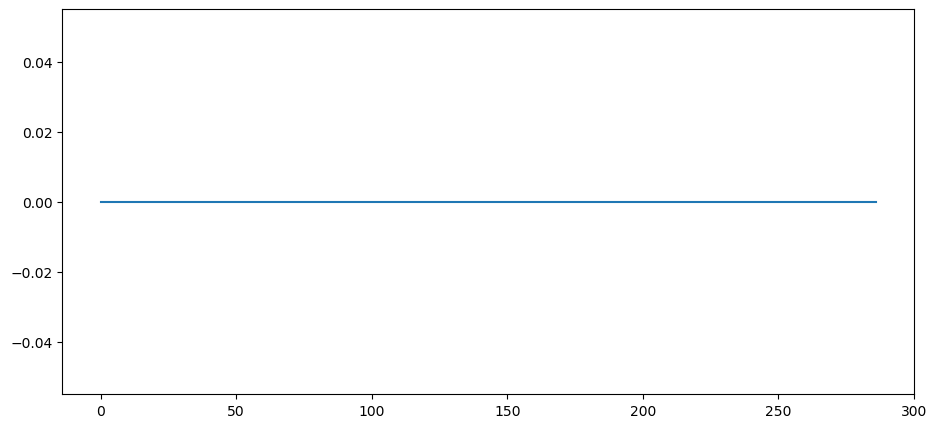

In [44]:
window = 10000
start, end = 0, window
sums = []
while end < ica_data.gene_table.end.max():
    sums.append(np.sum(all_pos[start:end + 1]))
    start = end
    end += window

fig, ax = plt.subplots(figsize=(11,5))

# ax.scatter(np.arange(len(sums)), sums)
ax.plot(sums)

In [45]:
muts = ['USA300HOU_RS00220', 'USA300HOU_RS00275',
       'USA300HOU_RS08120', 'USA300HOU_RS14885', 'USA300HOU_RS00230',
       'USA300HOU_RS04920', 'USA300HOU_RS15450', 'USA300HOU_RS12910',
       'USA300HOU_RS15460', 'USA300HOU_RS01405', 'USA300HOU_RS14870',
       'USA300HOU_RS01550', 'USA300HOU_RS01565', 'USA300HOU_RS10350',
       'USA300HOU_RS02590', 'USA300HOU_RS07705', 'USA300HOU_RS05470',
       'USA300HOU_RS12435', 'USA300HOU_RS00560', 'USA300HOU_RS04425', 
       'USA300HOU_RS03720', 'USA300HOU_RS14170', 'USA300HOU_RS04385',
       'USA300HOU_RS07870', 'USA300HOU_RS15640', 'USA300HOU_RS11215',
       'USA300HOU_RS02280', 'USA300HOU_RS02855', 'USA300HOU_RS03105',
       'USA300HOU_RS04765', 'USA300HOU_RS10780', 'USA300HOU_RS12565',
       'USA300HOU_RS00215', 'USA300HOU_RS10885', 'USA300HOU_RS10615',
       'USA300HOU_RS14000', 'USA300HOU_RS13270', 'USA300HOU_RS04930',
       'USA300HOU_RS07390', 'USA300HOU_RS12605', 'USA300HOU_RS08285',
       'USA300HOU_RS10605', 'USA300HOU_RS02380', 'USA300HOU_RS04470']

In [46]:
ica_data.trn[ica_data.trn.gene_id.isin(muts)]

,regulator,TF_id,trn_type,gene_name,N315_gene_id,gene_id
102,RbsR,SA0261,TF,rbsD,SA0259,USA300HOU_RS01405
105,RbsR2,NaN,TF,rbsD,SA0259,USA300HOU_RS01405
224,GltC,SA0429,TF,gltD,SA0431,USA300HOU_RS02380
346,CodY,SA1098,TF,opuCA,SA2237,USA300HOU_RS13270
408,CodY,SA1098,TF,gltD,SA0431,USA300HOU_RS02380
442,CodY,SA1098,TF,argH,SA0821,USA300HOU_RS04765
444,CodY,SA1098,TF,appD,SA0851,USA300HOU_RS04920
446,CodY,SA1098,TF,appB,SA0853,USA300HOU_RS04930
457,CodY,SA1098,TF,yocS,SA2112,USA300HOU_RS12565
530,CcpA,SA1557,TF,rbsD,SA0259,USA300HOU_RS01405


# DBGWAS Analysis

In [67]:
import pandas as pd
from Bio import SeqIO

import sys
sys.path.append('/home/saugat/Desktop/pymodulon/src/')
from pymodulon import core, io
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
df = pd.read_csv('data/dbgwas_postprocess/kmer_md.csv', index_col=0)

matched = df[~df['TCH1516_feats'].isnull()]

In [16]:
lt_to_prod = {}
for refseq in SeqIO.parse('/home/saugat/Desktop/Reference/genome/TCH1516.gb', 'genbank'):
    for feat in [f for f in refseq.features if f.type in ['CDS']]:
        if 'locus_tag' not in feat.qualifiers:
            continue
        lt_to_prod.update({feat.qualifiers['locus_tag'][0]: feat.qualifiers['product'][0]})

In [21]:
for idx, row in matched.iterrows():
    lts = row.TCH1516_feats.replace('(intergenic)', '')
    lts = lts.split(';')
    prod = []
    for l in lts:
        try:
            prod.append(lt_to_prod[l])
        except KeyError:
            print(l)
    matched.loc[idx, 'product'] = ';'.join(prod)

USA300HOU_RS09770


/home/saugat/anaconda3/envs/ete3/lib/python3.6/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/saugat/anaconda3/envs/ete3/lib/python3.6/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/home/saugat/anaconda3/envs/ete3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

In [31]:
ica_data = io.load_json_model('/home/saugat/Desktop/StaphPrecise2/docker_run/processed_data/saureus.json.gz')

In [33]:
ica_data.imodulons_with('USA300HOU_RS00560')

[]

In [23]:
matched.to_csv('/home/saugat/Desktop/manual_check.csv')

In [45]:
imods = []
for idx, row in matched.iterrows():
    lts = row.TCH1516_feats.replace('(intergenic)', '')
    lts = lts.split(';')
    for l in lts:
        try:
            imods = ica_data.imodulons_with(l)
            if imods:
                imods.extend(ica_data.imodulons_with(l))
                if l in lt_to_prod:
                    print(imods, lt_to_prod[l], l)
        except ValueError:
            continue

['Beta-Lactam Resistance', 'pUSA300HOUMR', 'Beta-Lactam Resistance', 'pUSA300HOUMR'] PBP2a family beta-lactam-resistant peptidoglycan transpeptidase MecA USA300HOU_RS00160
['scfm2-artefact', 'scfm2-artefact'] ABC transporter ATP-binding protein USA300HOU_RS00380
['Genomic Island 9-1', 'Genomic Island 9-1'] site-specific integrase USA300HOU_RS10860
['Fur-2', 'Fur-2'] iron ABC transporter permease USA300HOU_RS03510
['SigS-2', 'SigS-2'] arginine deiminase USA300HOU_RS00325
['Vir-2', 'Vir-2'] potassium-transporting ATPase A chain USA300HOU_RS11215
['Uncharacterized-6', 'Uncharacterized-6'] hypothetical protein USA300HOU_RS00785
['Uncharacterized-6', 'Uncharacterized-6'] hypothetical protein USA300HOU_RS00785
['SigB', 'SigB'] alpha/beta hydrolase USA300HOU_RS14000
['Genomic Island 9-2', 'Genomic Island 9-2'] ATPase USA300HOU_RS10780
['Genomic Island 9-2', 'Genomic Island 9-2'] hypothetical protein USA300HOU_RS15460
['Genomic Island 9-2', 'Genomic Island 9-2'] hypothetical protein USA300HOU_

In [46]:
nctc = io.load_json_model('/home/saugat/Desktop/modulome-workflow_NCTC8325/data/processed_data/NCTC8325.json.gz')

In [66]:
ica_data.gene_table.loc['USA300HOU_RS01175']

gene_name                      coa
accession              NC_010079.1
old_locus_tag       USA300HOU_0238
start                       266298
end                         268127
strand                           +
gene_product     staphylocoagulase
COG              No COG annotation
uniprot                 A0A0H2XHP9
operon                       Op151
regulator           SaeR,SigB,WalR
Name: USA300HOU_RS01175, dtype: object

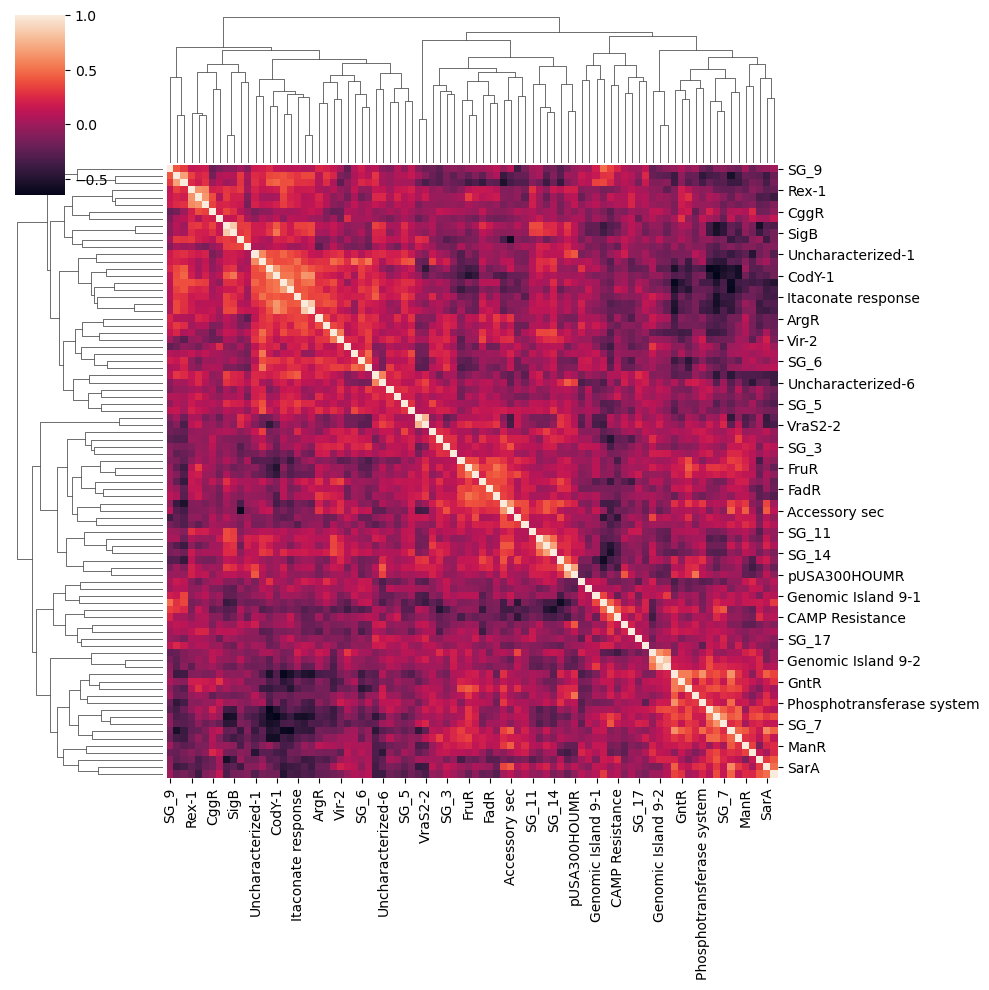

In [69]:
v